In [11]:
%load_ext autoreload
%autoreload 2

from tweedejaars_project import *
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from torch.utils.data import DataLoader, TensorDataset


df = load_df()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
features = [
    "import_capacity",
    # "min_price_published",
    "mid_price_published",
    # "max_price_published",
    # "upward_dispatch_published",
    # "downward_dispatch_published",
    # 'min_ptu_price_known',
    # "max_ptu_price_known",
    # "settlement_price_bestguess",
    'PTU',
    # 'forecast_wind',
    # 'forecast_solar',
    # 'forecast_demand',
    'time_since_last_two_sided',
    'two_sided_daily_count',
]

splits = get_splits(df, ['PTU', 'import_capacity'], return_dict_pair=False)

train_x = splits['train'][0]
train_y = splits['train'][1]

valid_x = splits['valid'][0]
valid_y = splits['valid'][1]
valid_ids = splits['valid'][2]


test_x = splits['test'][0]
test_y = splits['test'][1]
ids = splits['test'][2]

# scaler = StandardScaler()
# train_x = scaler.fit_transform(train_x)
# valid_x = scaler.transform(valid_x)

train_x_tensor = torch.tensor(train_x.values, dtype=torch.float32)
train_y_tensor = torch.tensor(train_y.values, dtype=torch.long)
valid_x_tensor = torch.tensor(valid_x.values, dtype=torch.float32)
valid_y_tensor = torch.tensor(valid_y.values, dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(train_x_tensor, train_y_tensor)
valid_dataset = TensorDataset(valid_x_tensor, valid_y_tensor)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False)

In [13]:
# # Generate a synthetic dataset with 13 features
# X, y = make_classification(n_samples=1000, n_features=13, n_classes=2, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Scale the features
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# # Convert to PyTorch tensors
# X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train, dtype=torch.long)
# X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
# y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# # Create DataLoader
# train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
# test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [14]:
class ImprovedSimpleNN(nn.Module):
    def __init__(self):
        super(ImprovedSimpleNN, self).__init__()
        self.fc1 = nn.Linear(train_x.shape[1], 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)
        self.dropout = nn.Dropout(0.5)  # Add dropout layer
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout
        x = F.relu(self.fc2(x))
        x = self.dropout(x)  # Apply dropout
        x = self.sigmoid(self.fc3(x))
        return x


In [15]:
# Hyperparameters
learning_rate = 0.2
num_epochs = 30

# Model, loss function, and optimizer
model = ImprovedSimpleNN()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
valid_losses = []  # List to store validation losses

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0  # Initialize epoch training loss
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item() * inputs.size(0)  # Accumulate the training loss
        
    epoch_train_loss /= len(train_loader.dataset)  # Calculate average training loss for the epoch
    train_losses.append(epoch_train_loss)  # Store the training loss value
    
    # Validation loop
    model.eval()  # Set model to evaluation mode
    epoch_valid_loss = 0.0  # Initialize epoch validation loss
    with torch.no_grad():
        for inputs, labels in valid_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            epoch_valid_loss += loss.item() * inputs.size(0)  # Accumulate the validation loss
            
    epoch_valid_loss /= len(valid_loader.dataset)  # Calculate average validation loss for the epoch
    valid_losses.append(epoch_valid_loss)  # Store the validation loss value
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Valid Loss: {epoch_valid_loss:.4f}')

# Plot both training and validation losses
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()


Epoch [1/30], Train Loss: 0.4080, Valid Loss: 0.4067
Epoch [2/30], Train Loss: 0.4077, Valid Loss: 0.4067


KeyboardInterrupt: 

Classification Report:
              precision    recall  f1-score   support

       False       0.89      1.00      0.94      2484
        True       0.00      0.00      0.00       300

    accuracy                           0.89      2784
   macro avg       0.45      0.50      0.47      2784
weighted avg       0.80      0.89      0.84      2784

Confusion Matrix:


/home/sakr/anaconda3/envs/tweedejaars_project/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sakr/anaconda3/envs/tweedejaars_project/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sakr/anaconda3/envs/tweedejaars_project/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

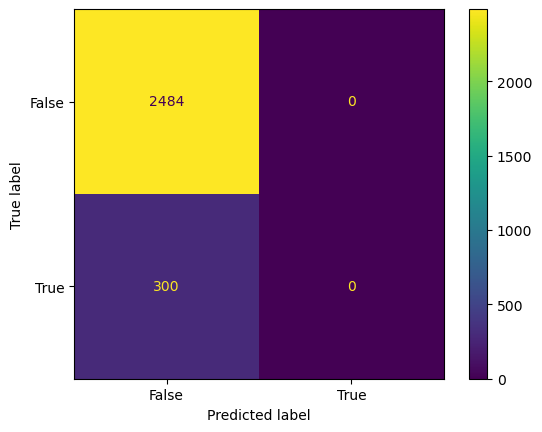

In [ ]:
# Testing the model
model.eval()  # Set the model to evaluation mode
y_pred = []
with torch.no_grad():
    for inputs, _ in valid_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.tolist())

# y_pred = np.array(y_pred)

show_basic_metrics(valid_y, y_pred, valid_ids)